We consider the problem of a two-dimensional laminar flow past a circular cylinder.
The fluid flow is governed by the 2D incompressible Navier-Stokes equations

$$
\begin{aligned}
    \partial_t \mathbf{u} + \nabla \cdot (\mathbf{u} \otimes \mathbf{u})
    &= \nabla p + Re^{-1}\Delta \mathbf{u}
    \\
    \nabla \cdot \mathbf{u}
    &= 0,
\end{aligned}
$$

where $p \in \mathbb{R}$ denotes the pressure, $\mathbf{u} = (u_x, u_y)^\mathsf{T} \in \mathbb{R}^2$ denotes the $x$ and $y$ components of the velocity vector, and $Re$ denotes the dimensionless Reynolds number (see https://en.wikipedia.org/wiki/Reynolds_number).


<font color='blue'> **Is this dynamical system linear?**</font>


The problem setup, geometry, and parameterization are given in the [DFG 2D-3 benchmark in the FeatFlow suite](https://wwwold.mathematik.tu-dortmund.de/~featflow/en/benchmarks/cfdbenchmarking/flow/dfg_benchmark2_re100.html).

We simulate the NS equations for $Re = 100$ with Finite Elements, using Gascoigne3D (https://gascoigne.math.uni-magdeburg.de/index.php?show=home). The dynamics are simulated for $T=8\;s$, using a timestep of $\Delta t = 0.01 \; s$ on a computational mesh with $n_x=10512$ nodes.

We first import the simulation data for the spatially discretized flow velocity,  $\mathbf{u}_d \in \mathbb{R}^{n}$, where $n=2 n_x$.
The corresponding snapshot matrix is $\mathbf{X}_o = \left[ \mathbf{u}_d(t=0), \mathbf{u}_d(t=0.01), \cdots \mathbf{u}_d(t=8) \right] \in \mathbb{R}^{2 n_x \times n_t}$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib import animation
import os

# Download the data file from Zenodo if it doesn't exist
if not os.path.exists("cylinder_data.h5"):
    !wget -O cylinder_data.h5 https://zenodo.org/record/18600528/files/cylinder_data.h5?download=1

#%% Load data for flow over cylinder

# .h5 file with all necessary fields
f = h5py.File("cylinder_data.h5", "r")

#Load flow coordinates
points_x = f["coordinates/x"]
points_y = f["coordinates/y"]

points = np.vstack([points_x, points_y])


Xu_h5 = f["fields/field_1"]   # h5py u velocity dataset
Xv_h5 = f["fields/field_2"]   # h5py v velocity dataset


X = np.vstack([Xu_h5[:], Xv_h5[:]])   # fully loads into RAM

#Select the periodic part of the snapshots
t_start = 500
nx = len(points_x)

X = X[:, t_start:]

nt = np.shape(X)[1]

dt = 0.01

t_end = np.shape(X)[1]

t = np.arange(0, t_end) * dt

--2026-02-11 10:05:42--  https://zenodo.org/record/18600528/files/cylinder_data.h5?download=1
Resolving zenodo.org (zenodo.org)... 188.184.98.114, 137.138.153.219, 188.185.43.153, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.114|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/18600528/files/cylinder_data.h5 [following]
--2026-02-11 10:05:43--  https://zenodo.org/records/18600528/files/cylinder_data.h5
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 84898316 (81M) [application/octet-stream]
Saving to: ‘cylinder_data.h5’

cylinder_data.h5    100%[===================>]  80.96M  23.1MB/s    in 4.6s    

2026-02-11 10:05:48 (17.5 MB/s) - ‘cylinder_data.h5’ saved [84898316/84898316]



We make a gif to really see what the imported data for the $x$ - velocity component look like.

<font color='blue'> **Can you create one gif also for the $y$ - velocity component dynamics?**</font>

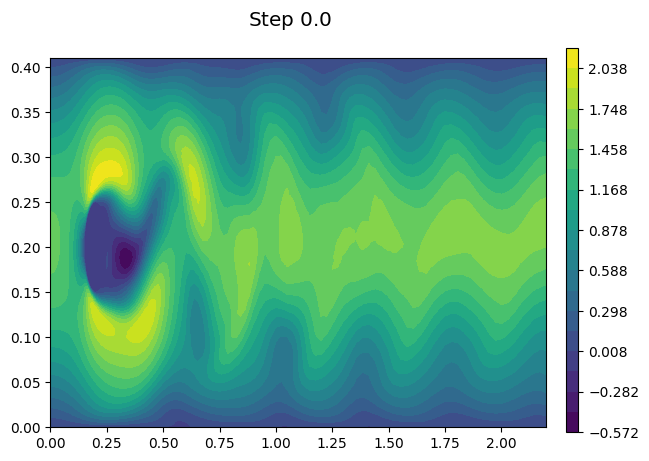

In [2]:

def gif2D_save(xdata, ydata, iterations, Q, name):
    """
    Simulation GIF creation
    """

    fig, ax = plt.subplots()
    cvals2 = np.linspace(np.min(Q),1.01*np.max(Q),20)
    a = ax.tricontourf(xdata, ydata, Q[:, 0], cvals2)
    ianim = iterations
    cb_ax = fig.add_axes([0.93, 0.1, 0.02, 0.8])
    #a.set_clim(np.min(Q),1.01*np.max(Q))
    fig.colorbar(a, cax=cb_ax)
    # animation function
    def anim_data(i):

        ax.clear()
        ax.tricontourf(xdata, ydata, Q[:, i], cvals2, cmap='viridis')
        fig.suptitle("Step ${:,.1f}$".format(i), fontsize="x-large")
    #Make an animation file and save it

    anim = animation.FuncAnimation(fig, anim_data, ianim, repeat=False)
    anim.save(name + '.gif')

#Create a gif for the simulation data
gif2D_save(points_x, points_y, np.arange(0, nt, 10), X[:nx], 'cylinder_flow_ux')

We first center the snapshot data with respect to their mean value $\overline{\mathbf{X}}_o \in \mathbb{R}^{2 n_x}$, such that

$\mathbf{X} = \mathbf{X}_o -  \overline{\mathbf{X}}_o$.

This is an important part for the SVD and all that follows.

Then, we perform the SVD of the snapshot matrix, $\mathbf{X} \in \mathbb{R}^{2\; n_x \times n_t}.

We split our centered snapshot data to $
\mathbf{X}_1 = \left[
\mathbf{x}_1, \mathbf{x}_2, \cdots, \mathbf{x}_{m-1}
\right]$, $
\mathbf{X}_2 = \left[
\mathbf{x}_2, \mathbf{x}_3, \cdots, \mathbf{x}_m
\right]$, where $m$ is the last training timestep.

Finally, we have a look on the singular value decay of $\mathbf{X}$. <font color='blue'> **What do you notice?**</font>

<font color='blue'> **Compare the singular value decay of $\mathbf{X}_o$ with that of $\mathbf{X}$.**</font>



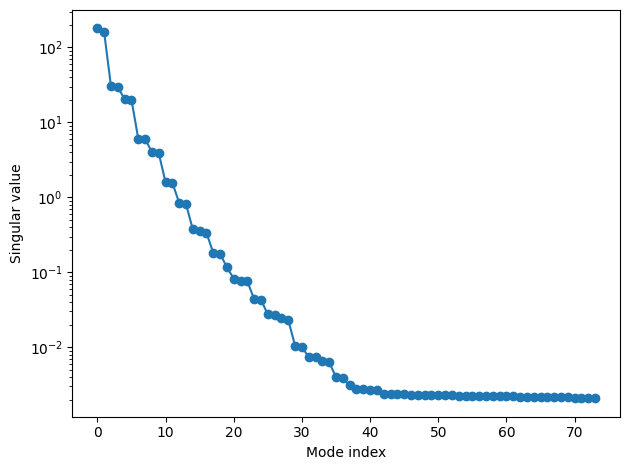

In [3]:

# -----------------------------
nt_train = np.floor(nt/4).astype(int) #Training data

# Center the data
X_mean = np.mean(X,axis=1)

X = X - X_mean.reshape(-1,1) @ np.ones([1, nt])

Xu = X[:nx]
Xv = X[nx:]

Χtrain = X[:, :nt_train]

# -----------------------------
# Construct data matrices
# -----------------------------
X1 = Χtrain[:, :-1]
X2 = Χtrain[:, 1:]


# -----------------------------
# SVD of X1
# -----------------------------
U, S, Vh = np.linalg.svd(X1, full_matrices=False)


#Plot the singular value decay
plt.figure()
plt.semilogy(S, marker='o')
plt.xlabel("Mode index")
plt.ylabel("Singular value")
plt.tight_layout()
plt.show()

We then truncate $r$ singular vectors.

<font color='blue'>**Can you compute what percentage of the total kinetic energy of the system is captured by the first $20$ singular vectors?**</font>


In [4]:
# Truncate
r = 20  # truncation rank
Ur = U[:, :r]
Sr = np.diag(S[:r])
Vr = Vh.T[:, :r]

We also plot some of those singular vectors. <font color='blue'>**Feel free to plot other singular vectors.**</font>

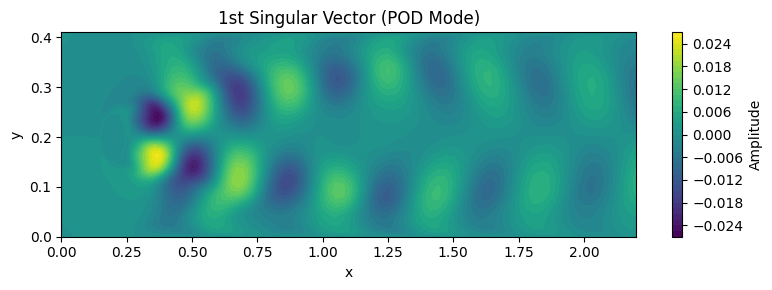

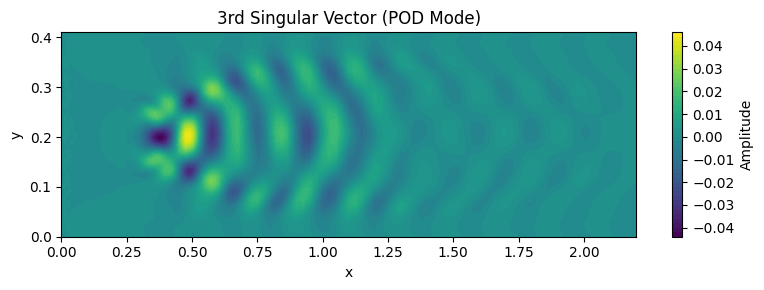

In [5]:

#Plot some selected singular vectors
plt.figure(figsize=(8, 3))
plt.tricontourf(points_x, points_y, U[:nx,0], levels=50, cmap="viridis")
plt.colorbar(label="Amplitude")
plt.title("1st Singular Vector (POD Mode)")
plt.xlim([np.min(points_x), np.max(points_x)])
plt.ylim([np.min(points_y), np.max(points_y)])
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 3))
plt.tricontourf(points_x, points_y, U[:nx,2], levels=50, cmap="viridis")
plt.colorbar(label="Amplitude")
plt.title("3rd Singular Vector (POD Mode)")
plt.xlim([np.min(points_x), np.max(points_x)])
plt.ylim([np.min(points_y), np.max(points_y)])
plt.xlabel("x")
plt.ylabel("y")
plt.tight_layout()
plt.show()

We are now ready to perform DMD.

Remember: Our aim is to infer a linear ROM in discrete time.

We approximate the discrete time dynamics as
$
\mathbf{X}_2 \approx \mathbf{A}\mathbf{X}_1,
$
where $\mathbf{A}$ is a linear operator that approximates the underlying dynamics.

<font color='blue'> **What is the dimension of $\mathbf{A}$ in this case?**</font>

Since $\mathbf{A}$ is high-dimensional, a reduced representation is obtained by computing the truncated singular value decomposition (SVD) of $\mathbf{X}_1$, $\mathbf{X}_1 \approx \mathbf{U}_r \boldsymbol{\Sigma}_r \mathbf{V}_r^*$, with $\mathbf{U}_r \in \mathbb{R}^{n \times r}$.


Projecting the dynamics onto this subspace yields the reduced operator
$
\hat{\mathbf{A}} = \mathbf{U}_r^* \mathbf{X}_2 \mathbf{V}_r \boldsymbol{\Sigma}_r^{-1}.
$
which results to

$\widehat{\mathbf{x}}_{k+1} \approx \hat{\mathbf{A}}\widehat{\mathbf{x}}_k \quad \left(1\right)$,

with ${\mathbf{x}} \approx \mathbf{U}_r \widehat{\mathbf{x}}$.

<font color='blue'> **What is the dimension of $\hat{\mathbf{A}}$ in this case?**</font>

An eigenvalue decomposition of $\hat{\mathbf{A}}$ provides the DMD eigenvalues and modes, which characterize the temporal growth rates and frequencies of the dominant flow structures.

We can then directly perform time integration of the reduced-order system, followed by projection back to the full state space.

In [6]:
# -----------------------------
A_tilde = Ur.T @ X2 @ Vr @ np.linalg.inv(Sr)

# -----------------------------
# Eigen-decomposition
# -----------------------------
eigvals, W = np.linalg.eig(A_tilde)

#These are the DMD modes
Phi = X2 @ Vr @ np.linalg.inv(Sr) @ W

Lets plot the eigenvalues of $\hat{\mathbf{A}}$.

<font color='blue'>**When is the dynamical system $\left(1 \right)$ asymptotically stable?**</font>


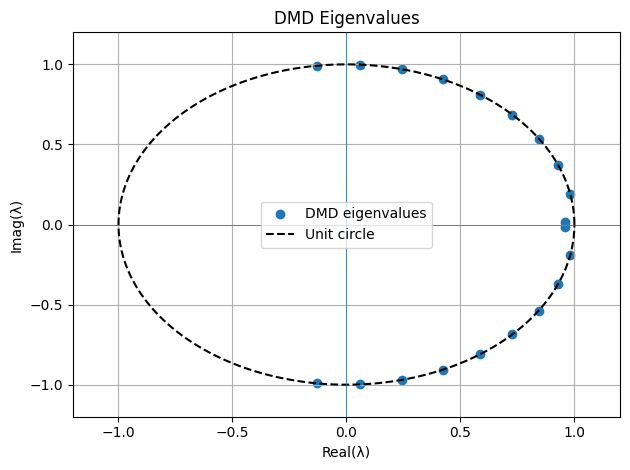

In [7]:
#Plot the eigenvalues in the unit circle
plt.scatter(
    eigvals.real,
    eigvals.imag,
    marker="o",
    label="DMD eigenvalues"
)
# Unit circle
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(
    np.cos(theta),
    np.sin(theta),
    "k--",
    label="Unit circle"
)
# Axes lines
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.xlabel("Real(λ)")
plt.ylabel("Imag(λ)")
plt.title("DMD Eigenvalues")
plt.xlim([-1.2, 1.2])
plt.ylim([-1.2, 1.2])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Now we will integrate $\left(1\right)$ in time and reconstruct the full system state.

In [8]:
#%% Simulate time dynamics

#Initial condition (projected)
x0_red = Ur.T @ X[:, 0]

timesteps = X.shape[1]

x_red = np.zeros([r, timesteps])
x_red[:, 0] = x0_red

for k in range(1, timesteps):
    x_red[:, k] = A_tilde @ x_red[:, k-1]

# -----------------------------
# Reconstruct data
# -----------------------------
X_dmd = Ur @ x_red

X_dmd_u = X_dmd[:nx]
X_dmd_v = X_dmd[nx:]

Lets compare the simulation data for $u_x$ at $t=8\;s$ with the reconstructed DMD predictions.

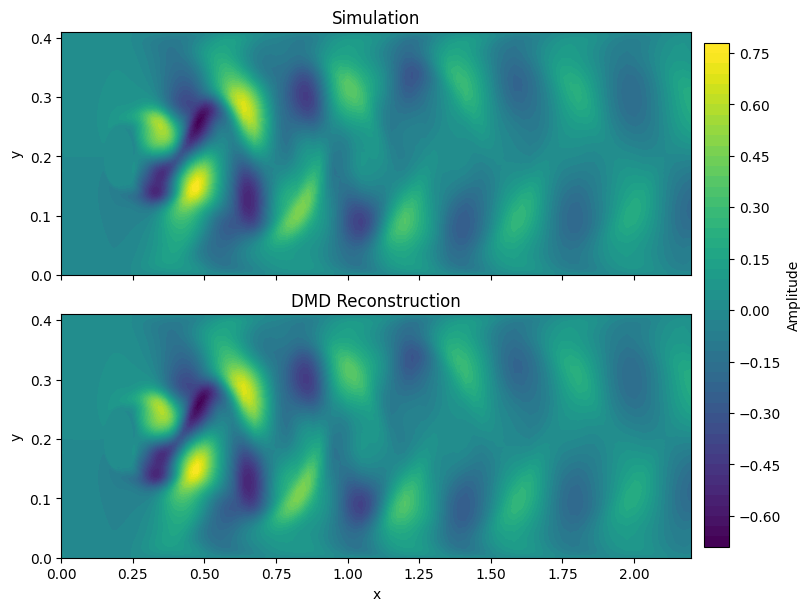

In [9]:
#%% Plot original vs reconstructed
# -----------------------------
t_plot = nt - 1

vmin = min(Xu[:, t_plot].min(), X_dmd_u[:, t_plot].min())
vmax = max(Xu[:, t_plot].max(), X_dmd_u[:, t_plot].max())

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(8, 6),
    sharex=True,
    sharey=True,
    constrained_layout=True   # ← key fix
)

# --- Simulation ---
c1 = axes[0].tricontourf(
    points_x,
    points_y,
    Xu[:, t_plot],
    levels=50,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title("Simulation")
axes[0].set_ylabel("y")

# --- DMD ---
axes[1].tricontourf(
    points_x,
    points_y,
    X_dmd_u[:, t_plot],
    levels=50,
    cmap="viridis",
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title("DMD Reconstruction")
axes[1].set_xlabel("x")
axes[1].set_ylabel("y")

# Axis limits (UNCHANGED, as requested)
axes[1].set_xlim(np.min(points_x), np.max(points_x))
axes[1].set_ylim(np.min(points_y), np.max(points_y))

# --- Common colorbar ---
cbar = fig.colorbar(
    c1,
    ax=axes,
    orientation="vertical",
    fraction=0.04,
    pad=0.02
)
cbar.set_label("Amplitude")

plt.show()

Finally, lets compare the timeseries for $u_y$ at a specific point in space.

<font color='blue'>**What do you notice happening beyond the training horizon?**</font>

<font color='blue'>**Change the probe location, and plot the $u_x$ velocity**</font>

<font color='blue'>**Try setting $t_{start}=200$ at the first code block. What do you observe in cases where more transient dynamics are included in the training data?**</font>

<font color='blue'>**Was our approximation for the dynamics in $\left(1\right)$ valid? Are the underlying dynamics of the simulation data linear?**</font>

<Figure size 3200x800 with 0 Axes>

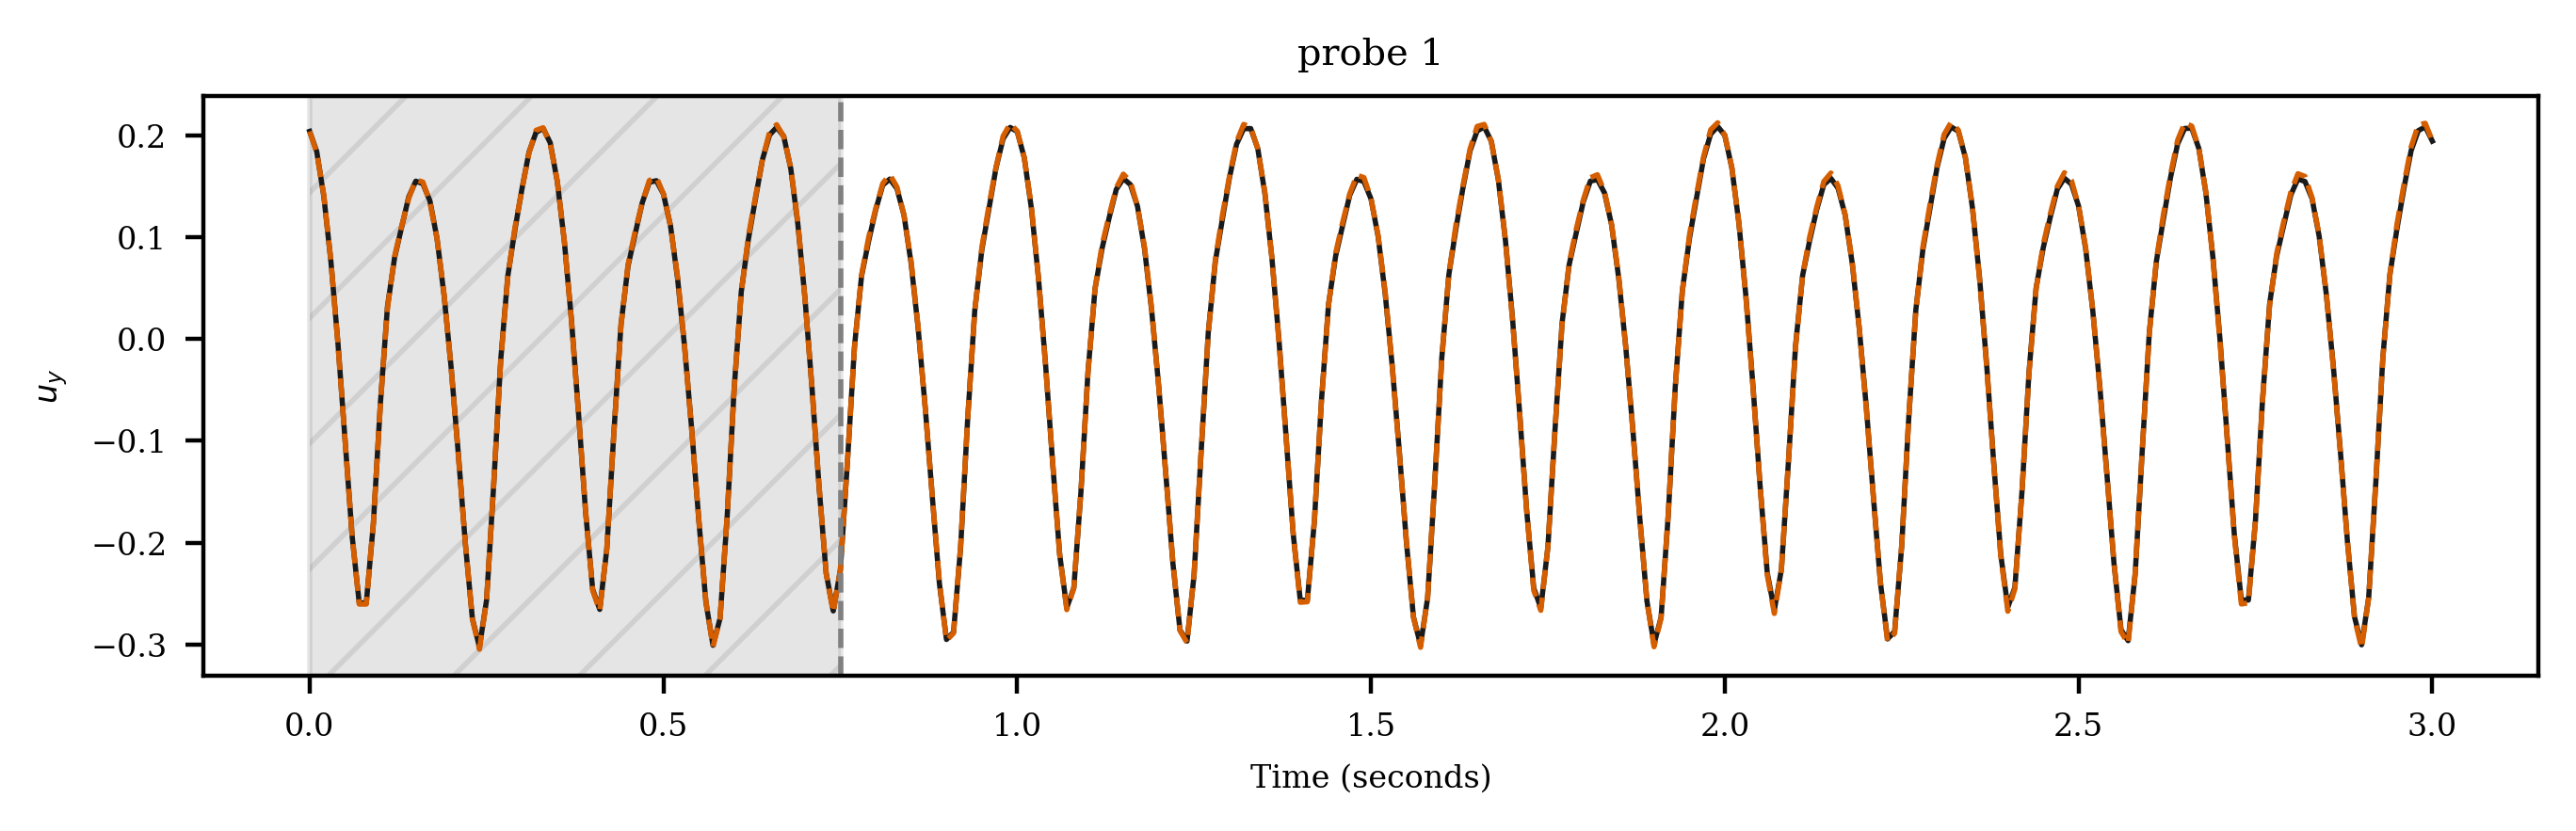

In [10]:

#Make a plot for a point in the wake
t_train = nt_train*dt
x_probe = 0.5
y_probe = 0.2
probe_dist = np.abs(np.array(points_x) - x_probe) + np.abs(np.array(points_y) - y_probe)

ind_probe = np.argwhere( probe_dist ==  np.min(probe_dist) ).flatten()

ind_probe1 = nx + ind_probe

sim_data_loc = Xu[ind_probe, :].flatten()

DMD_data_loc = X_dmd_u[ind_probe, :].flatten()

plt.rc("figure", dpi=400)
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none")
plt.rcParams["figure.figsize"] = (8, 2)
plt.rcParams.update({"font.size": 6})

charcoal = [0.1, 0.1, 0.1]
color1 = "#D55E00"
color2 = "#0072B2"

fig = plt.figure()

fig, ax = plt.subplots()

ax.plot(t, sim_data_loc, linestyle="-", lw=1.00, color=charcoal)
ax.plot(t, DMD_data_loc, linestyle="--", lw=1.00, color=color1)

ax.axvline(x=t_train, lw=1.00, linestyle="--", color="gray")

ax.set_title("probe 1")
ax.set_ylabel(r"$u_y$")
ax.set_xlabel("Time (seconds)", y=-0.1)

# x-limits
xlim = ax.get_xlim()
ax.set_xlim(xlim[0], xlim[1])

# y-limits
ylim1 = ax.get_ylim()
h1 = np.abs(ylim1[0]) + np.abs(ylim1[1])

# training region rectangle
rect1 = plt.Rectangle(
    (0, ylim1[0]),
    width=t_train,
    height=h1,
    hatch="/",
    color="grey",
    alpha=0.2,
    label="training region",
)
ax.add_patch(rect1)

plt.show()